In [1]:
from toolz import *

import pandas as pd
import numpy as np
from scipy.special import expit

from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use("ggplot")

# 24 - La Saga de la Différence-en-Différences

Après avoir discuté de l'hétérogénéité des effets du traitement, nous allons maintenant revenir aux effets moyens du traitement. Au cours des prochains chapitres, nous aborderons certains développements récents des méthodes de données de panel. Un panel est une structure de données qui contient des observations répétées au fil du temps. Le fait d'observer la même unité sur plusieurs périodes nous permet de voir ce qui se passe avant et après qu'un traitement ait lieu. Cela fait des données de panel une alternative prometteuse pour identifier les effets causaux lorsque la randomisation n'est pas possible.

Pour motiver l'utilisation des données de panel, nous parlerons principalement des applications d'inférence causale en marketing. Le marketing est particulièrement intéressant en raison de sa difficulté notoire à réaliser des expériences randomisées. Dans le marketing, nous ne pouvons souvent pas contrôler qui reçoit le traitement, c'est-à-dire qui voit nos publicités. Lorsqu'un nouvel utilisateur arrive sur notre site ou télécharge notre application, nous n'avons aucun moyen sûr de savoir si cet utilisateur est venu parce qu'il a vu l'une de nos campagnes ou en raison d'un autre facteur.

(Remarque : Pour ceux qui sont plus familiers avec l'attribution marketing, je suis conscient des nombreux outils d'attribution qui visent à résoudre ce problème. Mais je suis également conscient de leurs nombreuses limitations).

Le problème est encore plus grand avec le marketing hors ligne. Comment savoir si une campagne télévisée a apporté une valeur excédant ses coûts ? À cause de cela, une pratique courante en marketing est les Geo-Expériences : nous lançons une campagne marketing dans une région géographique mais pas dans d'autres, et nous les comparons. Dans cette conception, les méthodes de données de panel sont particulièrement intéressantes : nous pouvons collecter des données sur une région entière (unité) sur plusieurs périodes de temps. Pour interpréter ce type de données et identifier l'effet causal, les méthodes les plus populaires appartiennent à la famille Doubles-Différences, aussi appelées Différence-en-Différences (DiD).

Les années 2020 et 2021 n'ont pas été faciles pour la plupart d'entre nous. Mais elles ont été particulièrement difficiles pour DiD. Beaucoup de recherches récentes ont mis en évidence des défauts graves dans ces méthodes, des défauts qui n'étaient pas bien connus auparavant. Ainsi, bien que nous ayons déjà un chapitre dans la première partie qui couvre DiD, le contenu y est plutôt introductif. Il ne couvre pas les nouvelles découvertes et les discussions effervescentes autour des méthodes de données de panel. Nous devrions maintenant y jeter un regard plus approfondi, en commençant par la Différence-en-Différences. Dans ce chapitre spécifique, je vais essayer de résumer les problèmes récemment découverts avec DiD et aussi montrer comment les corriger. Ce chapitre est divisé en trois sections :

1. **Naissance** : Récapitulons pourquoi les données de panel sont si attrayantes pour l'inférence causale et comment DiD et les Effets Fixes à Deux Voies (TWFE) tirent parti de la structure temporelle en leur faveur.
2. **Mort** : Digestons une hypothèse clé implicite dans les modèles DiD et TWFE qui a été négligée. Comprenons quand et comment cette hypothèse peut échouer.
3. **Éveil** : Sachant le problème avec DiD et TWFE, nous pouvons maintenant penser à une solution. Cette partie montre une solution simple au problème exploré dans la section 2.

Allons-y !

## 1) Naissance : La Promesse des Données de Panel

Comme je l'ai dit, les données de panel sont lorsque nous avons plusieurs unités `i` sur plusieurs périodes de temps `t`. Pensez à un scénario d'évaluation de politique aux États-Unis, où vous voulez vérifier l'effet de la légalisation du cannabis sur le taux de criminalité. Vous avez des données sur le taux de criminalité dans plusieurs états `i` sur plusieurs périodes de temps `t`. Vous observez également à quel moment chaque état adopte une législation en faveur de la légalisation du cannabis. J'espère que vous pouvez voir pourquoi cela est incroyablement puissant pour l'inférence causale. Appelez la légalisation du cannabis le traitement `D` (puisque `T` est déjà pris ; il représente le temps). Nous pouvons suivre la tendance des taux de criminalité dans un état particulier qui finit par être traité et voir s'il y a des perturbations dans la tendance au moment du traitement. D'une certaine manière, un état sert de propre unité de contrôle, dans une comparaison avant et après. De plus, comme nous avons plusieurs états, nous pouvons également comparer les états traités aux états de contrôle. Lorsque nous combinons les deux comparaisons, traité vs contrôle et avant vs après traitement, nous obtenons un outil incroyablement puissant pour inférer des contrefactuels et, donc, des effets causaux.

Les méthodes de données de panel sont souvent utilisées dans l'évaluation des politiques gouvernementales, mais nous pouvons facilement faire valoir qu'elles sont également incroyablement utiles pour l'industrie (technologique). Les entreprises suivent souvent les données des utilisateurs sur plusieurs périodes de temps, ce qui donne une structure de données de panel riche. De plus, parfois, l'expérimentation n'est pas possible, nous devons donc nous appuyer sur d'autres stratégies d'identification. Pour explorer cette idée plus en profondeur, considérons un exemple hypothétique d'une jeune entreprise technologique qui suit le nombre de personnes ayant installé son application dans plusieurs villes. À un moment donné en 2021, l'entreprise technologique a lancé une nouvelle fonctionnalité dans son application. Elle souhaite maintenant savoir combien de nouveaux utilisateurs cette fonctionnalité a apportés à l'entreprise. Le déploiement a été progressif. Certaines villes ont obtenu la fonctionnalité le `2021-06-01`. D'autres, le `2021-07-15`. Le déploiement complet pour le reste des villes n'a lieu qu'en 2022. Comme nos données ne vont que jusqu'au `2021-07-31`, ce dernier groupe peut être considéré comme le groupe de contrôle. En termes d'inférence causale, le lancement de cette fonctionnalité peut être vu comme le traitement et le nombre d'installations peut être vu comme le résultat. Nous voulons connaître l'effet du traitement sur le résultat, c'est-à-dire l'effet de la nouvelle fonctionnalité sur le nombre d'installations.

Remarquez comment l'entreprise technologique ne peut pas faire d'expérience ici. Elle ne peut pas contrôler quelle personne sait qu'elle a une nouvelle fonctionnalité. On dit qu'ils ont un contrôle limité sur l'attribution du traitement. C'est parce que l'unité d'analyse est **les personnes qui ne sont pas encore leurs clients**. Ils veulent savoir combien de ces personnes ils peuvent convertir en clients en installant leur application. Bien sûr, ils ne peuvent rien randomiser pour ces personnes. Alors, à la place, ils ont changé l'unité d'analyse pour les villes. Le déploiement dans une ville par rapport à une autre est quelque chose qu'ils peuvent contrôler, ce qui n'est pas le cas du déploiement pour une personne par rapport à une autre.

Le groupe de villes qui a obtenu la fonctionnalité (a été traité) à un moment donné est appelé une cohorte. Dans notre cas, nous avons trois cohortes : une qui a été traitée le `2021-06-01`, une autre le `2021-07-15` et une cohorte de contrôle, qui ne sera traitée qu'après la fin de nos données. Pour avoir une idée de ce à quoi ressemblent ces données, traçons les installations quotidiennes moyennes regroupées par cohorte.

In [2]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"] + d["w_seas"]/10,
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)


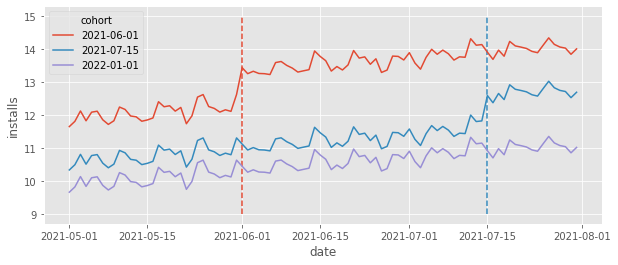

In [3]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

Les lignes pointillées marquent le moment où une cohorte a reçu le traitement (la fonctionnalité a été déployée). Prenez un moment pour apprécier la richesse des données représentées dans le graphique ci-dessus. Tout d'abord, on peut voir que chaque cohorte a son propre niveau de référence. C'est simplement parce que les différentes villes ont des tailles de population différentes, ce qui conduit à plus ou moins d'installations en fonction de la taille de la ville. Par exemple, il semble que les villes de la première cohorte (traitée le 01/06) ont un niveau de référence plus élevé, par rapport aux villes des autres cohortes. De plus, il semble que la cohorte de contrôle a un niveau de référence plus bas en termes d'installations. Cela signifie que comparer simplement les cohortes traitées aux cohortes de contrôle donnerait un résultat biaisé, puisque $Y_{0}$ pour le contrôle est inférieur à $Y_{0}$ pour les traités, ou $Y_{0}|G=Contrôle < $Y_{0}|G=Traités$, où nous utilisons $G$ pour désigner la cohorte. Heureusement, cela ne posera pas de problème. Les données de panel nous permettent de comparer les villes **et** le temps, ce qui permet d'ajuster les différents niveaux de référence.

En parlant de temps, notez qu'il y a une tendance générale à la hausse avec quelques ondulations (qui ressemblent à une saisonnalité hebdomadaire). En se concentrant sur la cohorte de contrôle, on observe que les installations quotidiennes sont passées d'environ 10 en mai à environ 11 en juin, une augmentation d'environ 1. En termes techniques, les périodes de temps ultérieures ont des $Y_{0}$ plus élevés que les périodes de temps antérieures. Cela signifie que comparer simplement les mêmes villes à travers le temps donnerait également des résultats biaisés. Encore une fois, nous avons la chance que la structure des données de panel nous permette de comparer non seulement à travers le temps, mais aussi à travers les villes, en ajustant les tendances.

Idéalement, pour inférer l'effet du déploiement de cette nouvelle fonctionnalité sur les installations, nous voulons savoir ce qui serait arrivé aux cohortes qui ont reçu la fonctionnalité, si elles ne l'avaient pas reçue. Nous voulons estimer le résultat contrefactuel $Y(0)$ dans les périodes post-traitement pour les cohortes traitées. Si nous désignons chaque cohorte par le moment où elle a été traitée `g` (rappelez-vous qu'une cohorte est simplement un groupe de villes qui ont été traitées en même temps), nous pouvons écrire ce contrefactuel comme $E[Y_0|t\geq g]$, ce qui nous permettrait ensuite de définir l'effet du traitement sur les traités (ATT) pour la cohorte `g` comme suit :

$$
E[Y_1|t \geq g] - E[Y_0|t\geq g]
$$

La prochaine question est de savoir comment nous pouvons estimer cela à partir des données dont nous disposons. Eh bien, une façon est d'exploiter la puissance de la structure des données de panel et d'estimer ces contrefactuels. Par exemple, nous pourrions utiliser la régression linéaire et la formulation Diff-in-Diff pour obtenir un modèle à Effets Fixes à Deux Voies. Supposons que chaque ville `i` ait un niveau de base d'installations $\gamma_i$. Cela revient à ce que nous avons vu plus tôt : peut-être qu'une ville a plus d'installations parce qu'elle a une plus grande population ou parce que sa culture est plus en ligne avec le produit de notre entreprise technologique. Quelle que soit la raison, et même si nous ne savons pas pourquoi, nous disons que ces idiosyncrasies d'unité peuvent être capturées par un **paramètre fixe dans le temps** $\gamma_i$. De même, nous pouvons dire que chaque période de temps `t` a un niveau de base d'installations que nous pouvons capturer par un **paramètre fixe d'unité** $\theta_t$. Si tel est le cas, une bonne manière de modéliser les installations est de dire qu'elles dépendent de l'effet ville (unité) $\gamma$ et de l'effet temps $\theta$, plus un bruit aléatoire.

$$
Installs_{it} = \gamma_i + \theta_t + e_{it}
$$

Pour inclure le traitement dans ce tableau, définissons une variable $D_{it}$ qui est égale à 1 si l'unité est traitée et à zéro sinon. Dans notre exemple, cette variable serait toujours égale à zéro pour la cohorte jamais traitée. Elle serait également égale à zéro pour toutes les autres cohortes au début, mais elle deviendrait égale à 1 le 01/06 pour la cohorte traitée le 01/06 et resterait à 1 après cela. De même, elle deviendrait égale à 1 le 15/07 pour la cohorte traitée le 15/07. Nous pouvons inclure ces indicateurs de traitement dans notre modèle d'installations comme suit :

$$
Installs_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$

Estimer le modèle ci-dessus avec les moindres carrés ordinaires (OLS) est ce qu'on appelle le Modèle à Effets Fixes à Deux Voies (TWFE). Notez que $\tau$ serait l'effet du traitement, car il nous indique de combien les installations changent une fois les unités traitées.

Une autre façon de le voir est d'invoquer la propriété de "maintien des choses constantes" de la régression linéaire. Si nous estimons le modèle ci-dessus, nous pourrions lire l'estimation de $\tau$ comme le changement des installations si nous passons le traitement de 0 à 1 tout en maintenant l'unité `i` et le temps `t` fixes.

Remarquez à quel point c'est audacieux ! Dire que nous maintiendrions chaque unité fixe tout en voyant comment $D$ change le résultat, c'est dire que nous contrôlons toutes les caractéristiques spécifiques à l'unité qui sont constantes dans le temps, connues et inconnues. Par exemple, nous contrôlerions le niveau de base des installations des villes, que nous pouvons mesurer, mais aussi des éléments dont nous n'avons aucune idée, comme la mesure dans laquelle la culture d'une ville est en ligne avec notre produit. La seule exigence est que cette caractéristique soit fixe au cours du temps de l'analyse. De plus, dire que nous maintiendrions chaque période de temps fixe revient à dire que nous contrôlons toutes les caractéristiques spécifiques à l'année. Par exemple, puisque nous maintenons l'année fixe, tout en regardant l'effet de $D$, nous contrôlerions la tendance et les saisonnalités que nous avons vues plus tôt.

Pour voir tout ce pouvoir en action, il nous suffit de lancer un modèle OLS avec l'indicateur de traitement $D$ (`treat` ici), plus des variables indicatrices pour les unités et le temps. Dans notre exemple particulier, j'ai généré des données de telle manière que l'effet du traitement (nouvelle fonctionnalité) est d'augmenter les installations de 1. Remarquez comment TWFE peut parfaitement récupérer cet effet de traitement :

In [4]:
formula = f"""installs ~ treat + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df).fit()

twfe_model.params["treat"]

1.0000000000000533

Comme j'ai simulé les données ci-dessus, je connais exactement le véritable effet individuel du traitement, qui est stocké dans la colonne `tau`. Étant donné que le modèle TWFE devrait récupérer l'effet du traitement sur les unités traitées, nous pouvons vérifier que le véritable ATT correspond à celui estimé précédemment. Tout ce que nous avons à faire est de filtrer les unités et les périodes traitées (`treat==1`) et de prendre la moyenne de la colonne `tau`.

In [5]:
df.query("treat==1")["tau"].mean()

1.0

Avant que quelqu'un ne vienne dire qu'il est impossible de générer une colonne factice pour chaque unité avec de grandes quantités de données, permettez-moi de vous dire que, oui, c'est vrai. Mais il existe une solution simple. Nous pouvons utiliser le théorème FWL pour diviser cette régression en deux. En fait, exécuter le modèle ci-dessus est numériquement équivalent à estimer le modèle suivant :

$$
\tilde{Installs}_{it} = \tau \tilde D_{it} + e_{it}
$$

où 

$$
\tilde{Installs}_{it} = Installs_{it} - \underbrace{\frac{1}{T}\sum_{t=0}^T Installs_{it}}_\text{Moyenne Temporelle} - \underbrace{\frac{1}{N}\sum_{i=0}^N Installs_{it}}_\text{Moyenne des Unités}
$$

et

$$
\tilde{D}_{it} = D_{it} - \frac{1}{T}\sum_{t=0}^T D_{it} - \frac{1}{N}\sum_{i=0}^N D_{it}
$$

En termes simples, si les équations semblent trop complexes, nous soustrayons la moyenne des unités au fil du temps (premier terme) et la moyenne temporelle à travers les unités (deuxième terme) de l'indicateur de traitement et de la variable de résultat pour construire les résidus. Ce processus est souvent appelé dé-moyennage, car nous soustrayons la moyenne du résultat et du traitement. Enfin, voici exactement la même chose, mais en code :

In [6]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("unit")[col_to_demean].transform("mean")
                                        - df.groupby("date")[col_to_demean].transform("mean"))})


formula = f"""installs ~ treat"""
mod = smf.ols(formula,
              data=df
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="installs")))

result = mod.fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-11.4580,7.98e-16,-1.44e+16,0.000,-11.458,-11.458
treat,1.0000,2.02e-15,4.96e+14,0.000,1.000,1.000


Une autre chose que nous pouvons faire pour comprendre ce que fait le modèle TWFE est de tracer les prédictions contrefactuelles $\hat{Y_0}|t \geq g$. Cela est utile car ce que notre modèle considère comme l'effet du traitement $\hat{\tau}$ est simplement la différence estimée $Y_1 - \hat{Y_0}$. Examiner cette différence explicite peut nous éclairer sur ce que le modèle fait réellement. Dans le graphique ci-dessous, nous pouvons voir exactement cela, avec $\hat{Y_0}$ représenté par des lignes pointillées.

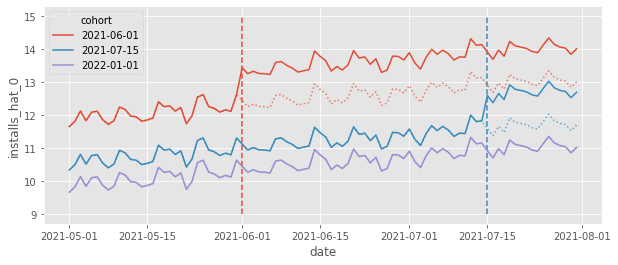

In [7]:
df_pred = df.assign(**{"installs_hat_0": twfe_model.predict(df.assign(**{"treat":0}))})
          

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    hue="cohort",
    alpha=0.7,
    ls="dotted",
    legend=None
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

Ce graphique nous montre comment TWFE projette la tendance qu'il voit dans les unités de contrôle sur les unités traitées et ajuste également les niveaux. Par exemple, si nous regardons la cohorte rouge, le $Y_0$ contrefactuel est la tendance moyenne des cohortes bleue et violette (projection de tendance) mais décalée au niveau de la cohorte rouge (ajustement de niveau). C'est pourquoi nous considérons TWFE comme une méthode de différence de différences. Il effectue également la projection des tendances et l'ajustement des niveaux, mais il fonctionne pour plusieurs périodes et plusieurs unités (dans le cas de 2 unités sur 2 périodes, TWFE et DiD sont équivalents).

## 2) Mort : Échecs dus à l'Hétérogénéité des Effets

Comme nous venons de le voir, la méthode DiD et le modèle TWFE ont leurs mérites. Ils peuvent bien estimer les contrefactuels, en prenant en compte les variations spécifiques au temps et aux unités. Cela en fait une technique puissante pour l'inférence causale. Mais si cela s'arrêtait là, ce chapitre ne serait pas nécessaire, car tout cela est largement couvert dans la première partie de ce livre. Ce qui s'est passé récemment, c'est que de nombreux universitaires ont remarqué que l'extension de la méthode DiD 2x2 à plusieurs périodes avec le modèle TWFE n'est pas aussi simple qu'on le pensait au départ. En fait, **TWFE, dans sa formulation habituelle, s'avère biaisé dans de nombreuses applications réelles**. Cet événement a entraîné une vague de révisions dans plusieurs études en économie qui s'appuyaient sur cette technique. Pour comprendre tout cela, le meilleur moyen est de commencer par énoncer l'hypothèse sous-jacente.

![img](data/img/did-saga/death.png)

Pour simplifier, considérons le modèle à effets fixes sans les effets temporels :

$$
y_{it} = \tau D_{it} + \gamma_i + e_{it}
$$

Nous pouvons regrouper les hypothèses que fait ce modèle en deux catégories :

1. Hypothèses de Forme Fonctionnelle :
    * Pas d'effets hétérogènes dans le temps (effets constants);
    * Linéarité dans les covariables;
    * Effets fixes additifs.
2. Exogénéité stricte :
    * Tendances parallèles;
    * Pas d'anticipation;
    * Pas de variables confondantes non observées variant dans le temps;
    * Les traitements passés n'affectent pas le résultat actuel (pas d'effet reporté);
    * Les résultats passés n'affectent pas le traitement actuel (pas de rétroaction).
    
Ici, nous allons nous concentrer sur les hypothèses de forme fonctionnelle. La linéarité dans les covariables est bien connue et s'applique à tous les modèles de régression linéaire. Mais, comme nous l'avons vu dans le chapitre sur le machine learning double/débié, nous pouvons facilement relâcher cette hypothèse avec un modèle de machine learning. Cela signifie que nous pouvons la détendre si nous le souhaitons. Quant à l'effet fixe additif, ce n'est pas une hypothèse trop restrictive, donc cela ne pose pas beaucoup de problèmes. Celle sur laquelle je veux me concentrer (et qui a généré beaucoup de débats) est celle concernant l'absence d'effets hétérogènes dans le temps.

### Hétérogénéité des Effets de Traitement dans le Temps

Si vous avez déjà travaillé dans le marketing ou la technologie, vous savez que les choses prennent du temps à mûrir. Si vous lancez une nouvelle fonctionnalité, il faudra du temps pour que les utilisateurs s'y habituent. De même, si vous lancez une campagne de marketing, l'effet de cette campagne ne sera pas instantané. Il mûrira avec le temps et pourra peut-être attirer de nouveaux utilisateurs même après la fin de la campagne. Ce **n'est pas** le schéma que nous avions dans les données d'installation que nous avons vues plus tôt. Là, les installations ont augmenté instantanément, au moment où la cohorte a été traitée. Que se passe-t-il si nous modifions cela pour être plus en phase avec ce que nous observons en réalité ? Notamment, faisons en sorte que l'ATT soit toujours de 1, mais que cela prenne maintenant 10 jours pour arriver à maturité (il sera donc de 0,1 le premier jour du traitement, 0,2 le deuxième jour du traitement, et ainsi de suite, jusqu'à atteindre 1 le dixième jour). De plus, je vais réduire la taille des effets temporels et des effets des unités pour que la tendance générale soit plus facile à voir.

In [8]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df_heter = pd.DataFrame(dict(
    date = np.tile(date.date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + 0.2*d["unit_fe"] + 0.05*d["time_fe"] + d["w_seas"]/50,
).assign(
    y1 = lambda d: d["y0"] + np.minimum(0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days)), 1)
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)


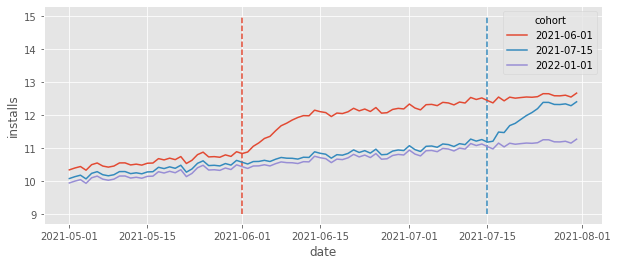

In [9]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_heter
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

Ce que nous voyons, c'est que les installations atteignent toujours le même niveau qu'auparavant, mais cela prend du temps (10 jours). Cela semble raisonnable, n'est-ce pas ? La plupart des données que nous observons dans la vie réelle fonctionnent ainsi, avec des effets qui mettent du temps à mûrir. D'accord, alors exécutons le modèle TWFE sur ces données pour voir ce qui se passe.

In [10]:
formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_heter).fit()

print("Estimated Effect: ", twfe_model.params["treat"])
print("True Effect: ", df_heter.query("treat==1")["tau"].mean())

Estimated Effect:  0.7867708225724858
True Effect:  0.8544117647058823


Tout d'abord, remarquez que le véritable ATT n'est plus égal à 1. En effet, il sera plus faible au cours des premières périodes. Deuxièmement, et surtout, nous pouvons constater que **l'ATT estimé par TWFE ne récupère plus le véritable ATT**. Pour faire simple : TWFE est biaisé. Mais pourquoi ? Nous avons des tendances parallèles, pas d'anticipation, et toutes les autres hypothèses d'exogénéité stricte sont respectées ici. Alors, que se passe-t-il ?

La première étape pour comprendre ce qui se passe est de réaliser que TWFE peut en fait être décomposé en plusieurs Diff-in-Diffs 2x2. Dans notre exemple, cela impliquerait des comparaisons entre les premiers traités et ceux qui ne sont jamais traités, les traités tardivement contre ceux qui ne sont jamais traités, les premiers traités contre les traités tardivement (avec les traités tardivement servant de contrôle), et les traités tardivement contre les premiers traités (avec les premiers traités étant le groupe de contrôle) :

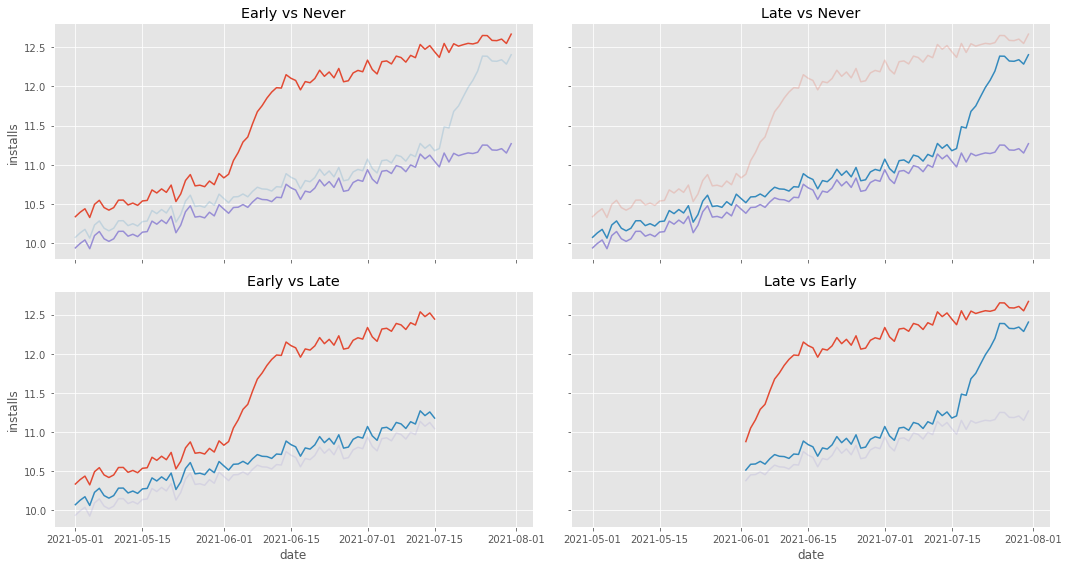

In [11]:
g_plot_data = (df_heter
               .groupby(["cohort", "date"])["installs"]
               .mean()
               .reset_index()
               .astype({"cohort":str}))


fig, axs = plt.subplots(2, 2, figsize=(15,8), sharex=True, sharey=True)

def plot_comp(df, ax, exclude_cohort, name):
    
    palette=dict(zip(map(str, cohorts), ["C0", "C1", "C2"]))
    
    sns.lineplot(
        data=df.query(f"cohort != '{exclude_cohort}'"),
        x="date",
        y="installs",
        hue="cohort",
        palette=palette,
        legend=None,
        ax=ax
    )

    sns.lineplot(
        data=df.query(f"cohort == '{exclude_cohort}'"),
        x="date",
        y = "installs",
        hue="cohort",
        palette=palette,
        alpha=0.2,
        legend=None,
        ax=ax
    )
    
    ax.set_title(name)

plot_comp(g_plot_data, axs[0,0], cohorts[1], "Early vs Never")
plot_comp(g_plot_data, axs[0,1], cohorts[0], "Late vs Never")

plot_comp(g_plot_data[g_plot_data["date"]<=cohorts[1]], axs[1,0], cohorts[-1], "Early vs Late")
plot_comp(g_plot_data[g_plot_data["date"]>cohorts[0]], axs[1,1], cohorts[-1], "Late vs Early")

plt.tight_layout();

Les trois premières comparaisons ne posent pas de problème, principalement parce que ce qu'elles utilisent comme groupe de contrôle se comporte très bien. Cependant, la quatrième comparaison, entre les traités tardivement et les traités tôt, est problématique. Remarquez que cette comparaison utilise les premiers traités comme groupe de contrôle. Notez également que ce groupe de contrôle, traité tôt, a un comportement étrange. Il augmente brusquement au début. Cela reflète le fait que notre ATT n'est pas instantané, mais prend plutôt 10 jours pour atteindre sa pleine maturité. Intuitivement, nous pouvons voir que cela perturbera l'estimation de la tendance contrefactuelle dans le DiD, la rendant plus raide qu'elle ne devrait l'être. Pour visualiser cela, traçons la tendance contrefactuelle estimée $Y_0$ pour les traités tardivement dans ce quatrième groupe.

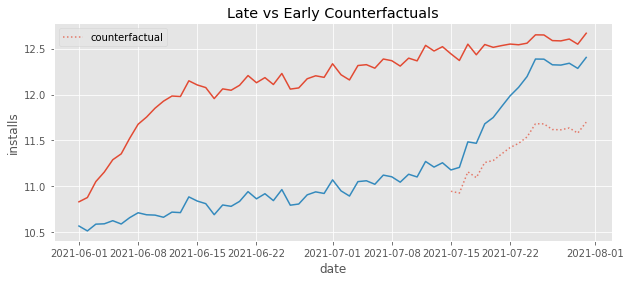

In [12]:
late_vs_early = (df_heter
                 [df_heter["date"].astype(str)>="2021-06-01"]
                 [lambda d: d["cohort"].astype(str)<="2021-08-01"])


formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=late_vs_early).fit()

late_vs_early_pred = (late_vs_early
                      .assign(**{"installs_hat_0": twfe_model.predict(late_vs_early.assign(**{"treat":0}))})
                      .groupby(["cohort", "date"])
                      [["installs", "installs_hat_0"]]
                      .mean()
                      .reset_index())


plt.figure(figsize=(10,4))
plt.title("Late vs Early Counterfactuals")
sns.lineplot(
    data=late_vs_early_pred,
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

sns.lineplot(
    data=(late_vs_early_pred
          [late_vs_early_pred["cohort"].astype(str) == "2021-07-15"]
          [lambda d: d["date"].astype(str) >= "2021-07-15"]
         ),
    x="date",
    y ="installs_hat_0",
    alpha=0.7,
    color="C0",
    ls="dotted",
    label="counterfactual"
);

Comme nous l'avons dit, les contrefactuels ont une tendance beaucoup plus raide qu'ils ne le devraient. Cela capture l'augmentation rapide au début du traitement précoce et projette cette tendance sur les unités traitées tardivement.

Plus techniquement, il a été démontré (Goodman-Bacon, 2019) que, même sous l'hypothèse d'exogénéité stricte (tendances parallèles, pas d'anticipation...), si les cohortes ont la même taille, l'estimateur TWFE convergera vers :

$$
plim_{x \to \infty} \hat{\tau}^{TWFE} = VWATT - \Delta ATT
$$

Le premier terme est l'ATT pondéré par la variance provenant de plusieurs comparaisons DiD, comme celles que nous avons vues précédemment. C'est ce que nous souhaitons obtenir. Cependant, il y a aussi ce terme supplémentaire $\Delta ATT$. Cela représente la variation de l'ATT au fil du temps et c'est ce qui biaise notre estimation. En examinant ce terme, nous pouvons voir que nous aurons un biais vers le bas si l'amplitude de l'effet augmente avec le temps (comme dans notre exemple) ou un biais vers le haut si l'amplitude de l'effet diminue avec le temps.

Dans l'exemple ci-dessus, nous avons vu que l'effet estimé par TWFE était inférieur au véritable ATT. Mais la situation peut être encore plus extrême. Il vaut la peine de passer en revue un dernier exemple pour montrer que ce biais peut être si fort qu'il peut même inverser le signe du véritable ATT. Considérons un processus très simple, avec seulement deux cohortes. Ici, l'effet du traitement sera négatif et diminuera de 0,1 chaque jour. J'ai également supprimé tous les effets fixes temporels et la tendance pour que nous puissions vraiment voir ce qui se passe.

In [13]:
date = pd.date_range("2021-05-15", "2021-07-01", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-06-15"])
units = range(1, 100+1)

np.random.seed(1)

df_min = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
)).assign(
    trend = 0,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 - d["trend"] + 0.1*d["unit_fe"]
).assign(
    y1 = lambda d: d["y0"] - 0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days))
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)


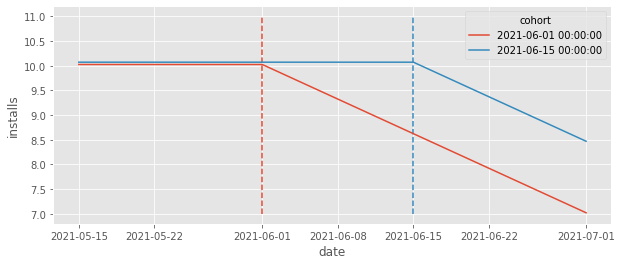

In [14]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_min
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

En regardant le graphique ci-dessus, nous pouvons clairement voir que l'ATT est négatif, n'est-ce pas ? Le contrefactuel correct devrait être une ligne droite à environ 11. Cependant, si nous exécutons l'estimateur TWFE, nous obtenons un effet positif !

In [15]:
formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_min).fit()

twfe_model.params["treat"]

0.04999999999998828

Encore une fois, pour comprendre ce qui se passe, concentrez votre attention sur la comparaison où la cohorte traitée tôt sert de groupe de contrôle pour la cohorte traitée tardivement. Rappelez-vous que, tout comme DiD, le modèle TWFE ajuste la tendance du groupe de contrôle au niveau du groupe traité, donc le contrefactuel devrait refléter cela.

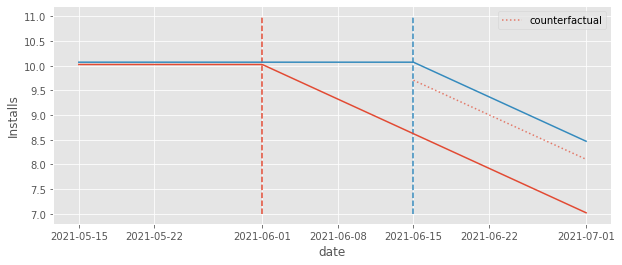

In [16]:
df_pred = df_min.assign(**{"installs_hat_0": twfe_model.predict(df_min.assign(**{"treat":0}))})
          
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C0",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

Remarquez comment le niveau contrefactuel est abaissé par rapport à l'endroit où il devrait être. Le fait que l'effet du groupe traité tôt soit en diminution a abaissé ce niveau de 10 à environ 9,5. De plus, le contrefactuel s'ajuste également à une tendance à la baisse, qui ne devrait pas être présente. Il est assez clair d'après le graphique que le contrefactuel correct devrait être une ligne droite à 10, mais au lieu de cela, c'est une ligne descendante, car c'est ce que le modèle observe dans le groupe traité tôt qu'il utilise comme contrôle.

Le résultat final est que le contrefactuel $Y_0$ est en fait inférieur au résultat $Y_1$, ce qui conduit à une estimation positive de l'impact. C'est assez embarrassant. En regardant simplement le graphique, nous pouvons facilement voir où devrait se trouver le bon contrefactuel (la ligne droite à 10). Pourtant, le modèle TWFE ne peut pas le retrouver, simplement parce qu'il utilise le groupe traité tôt comme contrôle pour le groupe traité tardivement.

#### Conception d'une Étude d'Événement

Pour éviter tout malentendu, je sais que certains pourraient penser que nous pouvons facilement résoudre ce problème en utilisant ce qu'on appelle une étude d'événement, où nous ajoutons une variable factice pour chaque période avant et après le traitement. Dans ce cas, nous remplaçons le modèle TWFE original par

$$
Y_{i,t} = \tau^{-K}~ D_{i,t}^{<-K} + \sum_{k=-K}^{-2} \tau^{lead} D_{i,t}^{k} +\sum_{k=0}^{L} \gamma_k^{lag} D_{i,t}^{k} + \gamma_k^{L+} D_{i,t}^{>L} \gamma_i + e_{it}
$$

où $D^k_{i,t}=1\{t-\text{Cohort}_i=k\}$ est une variable factice d'étude d'événement qui vaut 1 si l'unité est à `k` périodes du traitement et 0 sinon. Je sais que cela semble compliqué, mais en réalité, c'est très simple une fois que nous l'examinons à travers du code. Tout ce que nous devons faire est de créer une colonne `relative_days` qui mesure à quelle distance se trouve l'unité par rapport à la période où le traitement commence.

In [17]:
df_min_rel = (df_min
              .assign(relative_days = (df_min["date"] - df_min["cohort"]).dt.days))

df_min_rel.head()

,date,unit,cohort,unit_fe,trend,day,treat,y0,y1,tau,installs,relative_days
0,2021-05-15,1,2021-06-15,-3.435864,0,0,0,9.656414,9.656414,0.0,9.656414,-31
1,2021-05-16,1,2021-06-15,-3.435864,0,1,0,9.656414,9.656414,0.0,9.656414,-30
2,2021-05-17,1,2021-06-15,-3.435864,0,2,0,9.656414,9.656414,0.0,9.656414,-29
3,2021-05-18,1,2021-06-15,-3.435864,0,3,0,9.656414,9.656414,0.0,9.656414,-28
4,2021-05-19,1,2021-06-15,-3.435864,0,4,0,9.656414,9.656414,0.0,9.656414,-27


Ensuite, nous pouvons passer cette colonne en tant que catégorie afin que notre modèle estime le nombre attendu d'installations pour chaque période par rapport au traitement. Nous pouvons alors définir l'effet comme le nombre supplémentaire d'installations attendues par rapport au jour relatif -1, qui est le dernier jour avant le traitement.

On pourrait penser que cette formulation capturerait l'hétérogénéité temporelle dans l'ATT et résoudrait tous nos problèmes. Malheureusement, ce n'est pas le cas. Si nous essayons cette approche et traçons les contrefactuels, nous pouvons voir qu'ils sont loin de là où ils devraient être intuitivement (la ligne horizontale à 11).

In [18]:
# remove the intercept, otherwise effects will be relative to relative day -30
formula = f"installs ~ -1 + C(relative_days) + C(date) + C(unit)"

twfe_model = smf.ols(formula, data=df_min_rel).fit()

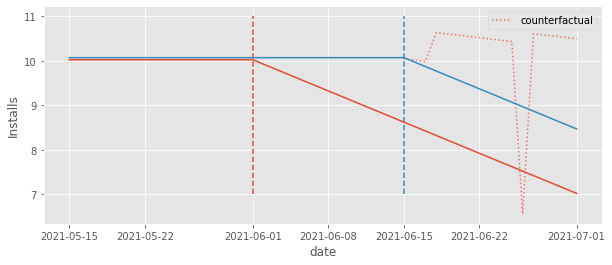

In [19]:
df_pred = df_min_rel.assign(
    installs_hat_0=twfe_model.predict(df_min_rel.assign(relative_days=-1))
) 

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C0",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

![img](data/img/did-saga/awful.jpeg)

Ces contrefactuels sont un peu meilleurs, cependant. Nous pouvons voir qu'ils se situent au-dessus du résultat réalisé $Y_1$. En conséquence, nous estimerons au moins un effet négatif, comme il se doit. Pour vérifier cela, nous pouvons tracer les effets estimés en extrayant d'abord le paramètre associé à chaque variable factice, puis en soustrayant de ceux-ci le paramètre associé au jour relatif -1 (la référence de base).

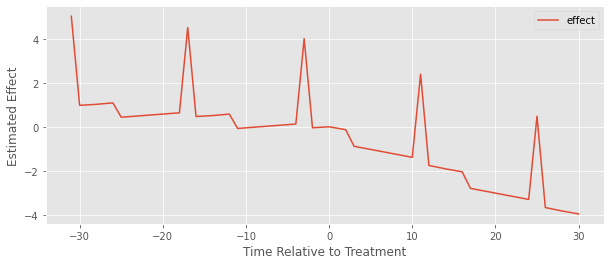

In [20]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("relative_days")]
           .reset_index()
           .rename(columns={0:"effect"})
           .assign(relative_day=lambda d: d["index"].str.extract(r'\[(.*)\]').astype(int))
           # set the baseline to period -1
           .assign(effect = lambda d: d["effect"] - d.query("relative_day==-1")["effect"].iloc[0]))

# effects
effects.plot(x="relative_day", y="effect", figsize=(10,4))
plt.ylabel("Estimated Effect")
plt.xlabel("Time Relative to Treatment");

On peut voir que c'est un peu mieux, car au moins l'effet estimé après le traitement est 1) principalement négatif et 2) généralement décroissant. Mais il y a ces pics étranges et ce qui ressemble à un effet pré-traitement positif, ce qui n'a évidemment aucun sens.

Le problème ici est le même que celui que nous avons discuté. Étant donné que le traitement a des moments différents, les unités traitées tôt sont utilisées comme contrôle pour les unités traitées tardivement, ce qui amène le modèle à estimer une tendance contrefactuelle très étrange. En fin de compte, ajouter des variables factices relatives au moment du traitement ne résout pas le problème, mais alors, qu'est-ce qui le résout vraiment ?

## 3) Éveil : Une Forme Fonctionnelle Flexible

Il y a des bonnes et des mauvaises nouvelles. D'abord, les bonnes nouvelles : nous avons identifié le problème comme étant lié à la forme fonctionnelle, donc nous pouvons le corriger en ajustant cette forme. Plus précisément, nous avons répété que ce biais spécifique dans TWFE provient des effets hétérogènes dans le temps. Cela peut se produire, entre autres raisons, parce que l'effet prend du temps à se concrétiser (par exemple, il peut falloir 10 jours à une campagne de marketing pour atteindre son plein potentiel). En d'autres termes, la forme fonctionnelle du TWFE traditionnel n'est tout simplement pas assez flexible pour capturer cette hétérogénéité, ce qui conduit au biais que nous avons discuté. Comme dans la plupart des cas, connaître le problème est déjà un grand pas vers la solution.

À la fin de la dernière section, nous avons vu que permettre simplement un effet différent pour chaque période par rapport au traitement (conception d'une étude d'événement) n'était pas suffisant. Même si cela n'a pas fonctionné, l'intention derrière cette approche était bonne. Elle a rendu le modèle plus flexible, mais pas suffisamment pour résoudre le problème. Nous devons penser à une autre manière de rendre le modèle encore plus flexible.

Pour cela, revenons à notre exemple initial, où nous essayions de modéliser le nombre d'installations supplémentaires que le déploiement d'une nouvelle fonctionnalité (traitement) nous a apporté. Nous avons vu que le modèle TWFE simple ne fonctionne pas ici :

$$
Installs_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$

De plus, nous savons qu'il ne fonctionne pas parce qu'il est trop restrictif. Il force l'effet à être le même \\(\tau_{it}=\tau \ \forall i, t\\), c'est-à-dire qu'il impose l'homogénéité temporelle. Si c'est le problème, une solution simple serait de permettre un effet différent pour chaque période et unité.

$$
Installs_{it} = \sum_{i=0}^N \sum_{t=0}^T \tau_{it} D_{it} + \gamma_i + \theta_t + e_{it}
$$

Cela équivaudrait à exécuter la formule suivante :
```
installs ~ treat:C(unit):C(date) + C(unit) + C(date)
```

Malheureusement, nous ne pouvons pas ajuster cela. Il y aurait plus de paramètres que de points de données. Comme nous interagissons les dates et les unités, nous aurions un paramètre d'effet de traitement pour chaque unité pour chaque période de temps $T*N$. Mais c'est exactement le nombre d'échantillons que nous avons ! OLS ne pourrait même pas fonctionner ici.

D'accord, maintenant, nous devons réduire le nombre de paramètres d'effet de traitement du modèle. Pour y parvenir, nous pouvons réfléchir à une manière de regrouper les unités. Si nous y réfléchissons un peu, nous pouvons voir une façon très naturelle de regrouper les unités : par cohorte ! Nous savons que l'effet dans une cohorte entière suit le même schéma dans le temps. Ainsi, une amélioration naturelle de ce modèle impraticable ci-dessus est de permettre à l'effet de changer par cohorte plutôt que par unité :

$$
Installs_{it} = \sum_{g=0}^G \sum_{t=0}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$

où `G` est le nombre total de cohortes et `g` représente chaque cohorte individuelle. Ce modèle a un nombre de paramètres d'effet de traitement beaucoup plus raisonnable ($T*G$) car $G$ est généralement beaucoup plus petit que $N$. Maintenant, nous pouvons enfin l'exécuter.

In [21]:
formula = f"""installs ~ treat:C(cohort):C(date) + C(unit) + C(date)"""

# for nicer plots latter on
df_heter_str = df_heter.astype({"cohort": str, "date":str})

twfe_model = smf.ols(formula, data=df_heter_str).fit()

Pour vérifier si ce modèle fonctionne, nous pouvons faire des prédictions contrefactuelles pour $Y_0$ en forçant la variable `treat` à être égale à zéro pour tout le monde. Ensuite, nous pouvons estimer l'effet en prenant le résultat observé pour le traitement, c'est-à-dire $Y_1$, et en soustrayant $\hat{Y}_0$ de celui-ci. Voyons si cela correspond au véritable ATT.

In [22]:
df_pred = (df_heter_str
           .assign(**{"installs_hat_0": twfe_model.predict(df_heter_str.assign(**{"treat":0}))})
           .assign(**{"effect_hat": lambda d: d["installs"] - d["installs_hat_0"]}))

print("Number of param.:", len(twfe_model.params))
print("True Effect: ", df_pred.query("treat==1")["tau"].mean())
print("Pred. Effect: ", df_pred.query("treat==1")["effect_hat"].mean())

Number of param.: 467
True Effect:  0.8544117647058823
Pred. Effect:  0.8544117647058977


Ça fonctionne ! Nous avons enfin réussi à créer un modèle suffisamment flexible pour capturer l'hétérogénéité temporelle, ce qui nous a permis d'estimer correctement l'effet du traitement. Une autre chose intéressante que nous pouvons faire est d'extraire les effets estimés par période et par cohorte, puis de les représenter graphiquement. Dans ce cas, comme nous savons comment les données ont été générées, nous savons à quoi nous attendre. Plus précisément, l'effet pour chaque cohorte doit être nul avant le traitement, puis atteindre 1 dix jours après le traitement, avec une ligne qui monte de zéro à 1 entre le jour du traitement et les dix jours qui suivent.

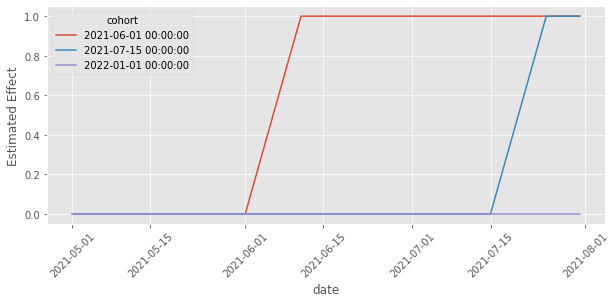

In [23]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("treat")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r'C\(cohort\)\[(.*)\]:'))
           .assign(date=lambda d: d["index"].str.extract(r':C\(date\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date"]), cohort=lambda d: pd.to_datetime(d["cohort"])))

plt.figure(figsize=(10,4))
sns.lineplot(data=effects, x="date", y="param", hue="cohort")
plt.xticks(rotation=45)
plt.ylabel("Estimated Effect");

Encore une fois, le graphique ci-dessus correspond à nos attentes concernant les effets. Ils suivent exactement le schéma que nous avons décrit précédemment.

C'est déjà très bien, mais nous pouvons faire encore mieux. Tout d'abord, remarquez que ce modèle comporte un grand nombre de paramètres. Comme nous avons 100 unités et environ 92 jours dans nos données, nous savons que 192 de ces paramètres sont les effets d'unité et de temps. Cependant, cela nous laisse encore plus de 250 paramètres d'effet de traitement.

Si nous supposons un effet nul avant le traitement (pas d'anticipation), nous pouvons réduire le nombre de paramètres en supprimant les dates avant le traitement du terme d'interaction.

$$
Installs_{it} = \sum_{g=0}^G \sum_{t=g}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$

De plus, nous pouvons supprimer de l'interaction les cohortes de contrôle, puisque leur effet avant le traitement est toujours nul.

$$
Installs_{it} = \sum_{G=q}^g \sum_{t=g}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$

où les cohortes avant $g<q$ sont définies comme des cohortes de contrôle.

Cependant, notez que cela est difficile à mettre en œuvre directement avec des formules, donc nous devons d'abord faire un peu de feature engineering. Concrètement, nous allons créer manuellement les variables factices de cohorte, en créant une colonne qui est égale à 1 lorsque la cohorte est `2021-06-01` et 0 sinon, et une autre colonne qui est égale à 1 lorsque la cohorte est `2021-07-15` et 0 sinon. De plus, nous allons créer une colonne de dates pour la cohorte `2021-06-01` qui regroupe toutes les dates antérieures à cette cohorte dans une catégorie de `contrôle`. Nous pouvons faire de même avec les dates de la cohorte `2021-07-15`. Voici à quoi cela ressemble en code :

In [24]:
def feature_eng(df):
    return (
        df
        .assign(date_0601 = np.where(df["date"]>="2021-06-01", df["date"], "control"),
                date_0715 = np.where(df["date"]>="2021-07-15", df["date"], "control"),)
        .assign(cohort_0601 = (df["cohort"]=="2021-06-01").astype(float),
                cohort_0715 = (df["cohort"]=="2021-07-15").astype(float))
    )

formula = f"""installs ~ treat:cohort_0601:C(date_0601) 
                       + treat:cohort_0715:C(date_0715) 
                       + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df_heter_str.pipe(feature_eng)).fit()

Si nous faisons maintenant des prédictions contrefactuelles comme précédemment, nous pouvons constater que l'effet estimé correspond toujours parfaitement à l'effet réel. Le gain ici est que nous avons un modèle beaucoup plus simple, avec seulement environ 80 paramètres d'effet de traitement (n'oubliez pas que 192 de ces paramètres sont les effets fixes de temps et d'unité).

In [25]:
df_pred = (df_heter
           .assign(**{"installs_hat_0": twfe_model.predict(df_heter_str
                                                           .pipe(feature_eng)
                                                           .assign(**{"treat":0}))})
           .assign(**{"effect_hat": lambda d: d["installs"] - d["installs_hat_0"]}))


print(len(twfe_model.params))
print("True Effect: ", df_pred.query("treat==1")["tau"].mean())
print("Pred Effect: ", df_pred.query("treat==1")["effect_hat"].mean())

271
True Effect:  0.8544117647058823
Pred Effect:  0.8544117647059067


En traçant les paramètres d'effet de traitement, nous pouvons voir comment nous avons supprimé ceux provenant de la cohorte de contrôle ainsi que ceux des dates précédant le traitement de la cohorte.

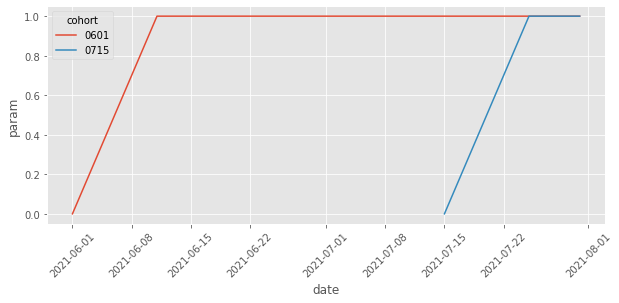

In [26]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("treat")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r':cohort_(.*):'),
                   date_0601=lambda d: d["index"].str.extract(r':C\(date_0601\)\[(.*)\]'),
                   date_0715=lambda d: d["index"].str.extract(r':C\(date_0715\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date_0601"].combine_first(d["date_0715"]), errors="coerce")))

           
plt.figure(figsize=(10,4))
sns.lineplot(data=effects.dropna(subset=["date"]), x="date", y="param", hue="cohort")
plt.xticks(rotation=45);

Remarquez que nous pourrions aller encore plus loin, puisque l'effet pour les deux cohortes suit la même forme. En d'autres termes, nous pourrions restreindre le modèle à avoir le même effet pour les deux cohortes, en ne changeant qu'au fil du temps. Pour ce faire, nous devrions créer une colonne pour représenter les jours après le traitement, comme dans la conception d'une étude d'événement. Cela ressemblerait à ceci :

```
days_after_treat = 1(date > cohort) * (date - cohort)
```

Ensuite, nous l'interagirions avec l'indicateur de traitement :

```
installs ~ treat:C(days_after_treat) + C(unit) + C(date)
```

Cependant, je pense que nous pouvons nous arrêter ici. Ne pas permettre l'hétérogénéité par cohorte est souvent une mauvaise idée, car l'effet du traitement a tendance à changer au fil du temps calendaire, et pas seulement en fonction du temps écoulé depuis le traitement. Par exemple, il pourrait arriver qu'après un certain temps, des concurrents copient notre fonctionnalité, la rendant moins attractive pour les clients qu'elle ne l'était autrefois. Dans ce cas, l'effet de la nouvelle fonctionnalité sur les installations diminuerait au fil du temps.

Une dernière chose que nous devrions faire, en plus de montrer les effets au fil du temps, est de tracer les contrefactuels pour voir s'ils se situent à un endroit qui semble correct. Je sais que ce n'est pas une validation très scientifique de notre modèle, mais croyez-moi, cela aide beaucoup. Alors, voici ce que cela donne.

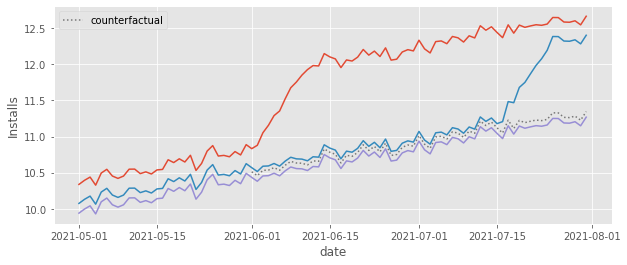

In [27]:
twfe_model_wrong = smf.ols("installs ~ treat + C(date) + C(unit)",
                           data=df_pred).fit()


df_pred = (df_pred
           .assign(**{"installs_hat_0_wrong": twfe_model_wrong.predict(df_pred.assign(**{"treat":0}))}))


plt.figure(figsize=(10,4))
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-01")]
          .groupby(["date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    ls="dotted",
    color="C3",
    label="counterfactual",
)

sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

plt.ylabel("Installs");

Comme nous pouvons le voir, la prédiction contrefactuelle $Y_0$ se situe exactement là où nous pensons qu'elle devrait être, c'est-à-dire assez proche de la cohorte de contrôle. C'est très rassurant. Nous savons que le modèle TWFE estime l'effet du traitement comme étant $Y-\hat{Y_0}$. Autrement dit, il compare simplement le résultat des cohortes traitées à ce contrefactuel. Puisque le contrefactuel semble correct, nous pouvons être raisonnablement sûrs que l'effet du traitement est également probablement correct.

C'est la bonne nouvelle, mais ne pensez pas que j'ai oublié la mauvaise nouvelle que je vous avais promise. Le problème, c'est que même si nous avons résolu le problème de la forme fonctionnelle avec TWFE, il reste encore un problème potentiellement plus important avec DiD et TWFE, qui est lié à l'hypothèse d'indépendance.

Lorsque nous utilisons DiD et TWFE, nous invoquons souvent l'hypothèse des tendances parallèles, sans vraiment réfléchir à ce que cela implique exactement. Malheureusement, l'hypothèse des tendances parallèles est beaucoup plus restrictive et moins plausible que ce que la plupart des gens réalisent. Mais comme ce chapitre est déjà assez long, je pense qu'il est préférable de le conclure ici, où nous pouvons encore savourer le goût d'une petite victoire pour DiD.

## Concepts Clés

Je pense qu'il est sûr de dire que nous avons finalement réussi non seulement à comprendre, mais aussi à corriger le problème de la forme fonctionnelle avec TWFE. Nous avons identifié le problème à sa racine (l'hétérogénéité temporelle) et l'avons corrigé en permettant plus de flexibilité. Nous pouvons maintenant nous détendre en sachant que TWFE est de nouveau sûr à utiliser. Ou est-ce vraiment le cas ?!

![img](data/img/did-saga/twfeworking.png)

Nous ne devons jamais oublier que TWFE (et DiD plus généralement) est un mélange de **formes fonctionnelles et d'hypothèses d'indépendance**. Dans ce chapitre, nous avons seulement abordé les problèmes de forme fonctionnelle, mais il reste encore un gros éléphant dans la pièce : l'hypothèse des tendances parallèles. Les tendances parallèles constituent l'hypothèse d'indépendance que fait DiD. C'est bien connu. Mais j'ai l'impression que nous ne comprenons pas vraiment ce que cette hypothèse implique. Nous l'invoquons simplement comme si cela suffisait à la rendre vraie. Malheureusement, l'hypothèse des tendances parallèles exige bien plus que ce que la plupart des gens réalisent. Dans les prochains chapitres, nous verrons pourquoi c'est le cas et si nous pouvons y faire quelque chose.

## Références

Ce chapitre a pris un temps (très) long à écrire. La littérature économétrique récente a émergé avec de nouvelles idées et des aperçus sur les problèmes liés à DiD et comment les résoudre. Il y a plusieurs angles sous lesquels nous pouvons voir ces problèmes, ce qui conduit à plusieurs approches que nous pouvons utiliser pour les résoudre. Préparez-vous, car la liste de références ici sera longue (et probablement pas très bien organisée).

Tout d'abord, j'ai beaucoup appris de *Difference-in-Differences with Variation in Treatment Timing*, d'Andrew Goodman-Bacon. Son diagnostic du problème est très clair et intuitif. Sans oublier qu'il propose de très belles illustrations qui m'ont donné une compréhension claire de ce qui se passait avec DiD. Certaines des illustrations de ce chapitre sont presque une copie directe de celles réalisées par Goodman-Bacon.

La deuxième source majeure d'inspiration était *Difference-in-Differences with Multiple Time Periods*, de Pedro H. C. Sant'Anna et Brantly Callaway. Remarquez que la solution de Callaway et Sant'Anna à ce problème prend une voie différente de celle que nous avons empruntée. Pourtant, leur solution éclaire beaucoup le problème de DiD, ce qui le rend facile à comprendre. En dehors de l'article, Pedro a publié un très bon billet de blog montrant les problèmes avec TWFE. Le processus de génération de données sur ce blog a fortement inspiré ceux que j'ai utilisés ici. J'ai essentiellement traduit le code de Pedro de R à Python. Pedro a également été très aimable en m'aidant avec certaines questions que j'avais sur les hypothèses de DiD. Il a un autre article très intéressant abordant le problème de l'ajout de covariables aux modèles DiD, que nous n'avons pas couvert ici car le chapitre était déjà trop long. Le nom de l'article est *Doubly Robust Difference-in-Differences Estimators*, et je vous recommande fortement de le lire si vous envisagez d'ajouter des covariables à votre modèle.

Enfin, mais certainement pas le moindre, la correction de la forme fonctionnelle que nous avons employée ici a été inspirée par *Estimating dynamic treatment effects in event studies with heterogeneous treatment effects* de Sun et Abraham et par *Two-Way Fixed Effects, the Two-Way Mundlak Regression, and Difference-in-Differences Estimators* de Jeffrey Wooldridge. Bien que j'aie beaucoup apprécié ce que Callaway et Sant'Anna ont fait dans leur article, leur solution est un peu plus compliquée à mettre en œuvre. En revanche, la solution de Sun, Abraham et Wooldridge consiste simplement à jouer intelligemment avec les interactions dans un modèle de régression TWFE, ce qui la rend super facile à implémenter en utilisant simplement `statsmodels` et quelques formules.

En plus des articles mentionnés ci-dessus, je me suis également appuyé sur des présentations données lors du DiD Study Group, organisé par Taylor Wright sur YouTube. Il est beaucoup plus facile de comprendre les articles mentionnés ci-dessus si vous regardez d'abord les auteurs en parler. Je suis également très reconnaissant au professeur Yiqing Xu d'avoir réuni tout cela dans sa série de conférences *Causal Inference with Panel Data*, également disponible sur YouTube.

Enfin, gardez à l'esprit que j'apprends aussi, donc, si vous trouvez quelque chose de contestable, n'hésitez pas à ouvrir un sujet, et je ferai de mon mieux pour y répondre.


## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).